In [1]:
# trying a simple training example
# the custom model

import torch
import torch.nn as nn
import numpy as np
from custom import (
    CustomLinear, 
    CustomReLU, 
    CustomLeakyReLU
)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [2]:
"""Define a few models for comparison, including a standard (all built in ops), custom, and mixed model
"""

bias_set = True

class CustomNeuralNet(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 hidden_size_2,
                 output_size):
        super(CustomNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size, bias=bias_set)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = CustomReLU()
        self.fc3 = CustomLinear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

class CustomLeakyNeuralNet(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 hidden_size_2,
                 output_size):
        super(CustomLeakyNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size, bias=bias_set)
        self.ac1 = CustomLeakyReLU()
        self.fc2 = CustomLinear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = CustomLeakyReLU()
        self.fc3 = CustomLinear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

#3 comparing the custom net with a standard net
class StandardNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(StandardNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=bias_set)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

#3 comparing the custom net with a standard net
class MixedNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(MixedNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size, bias=bias_set)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = CustomReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

class TinyNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TinyNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x


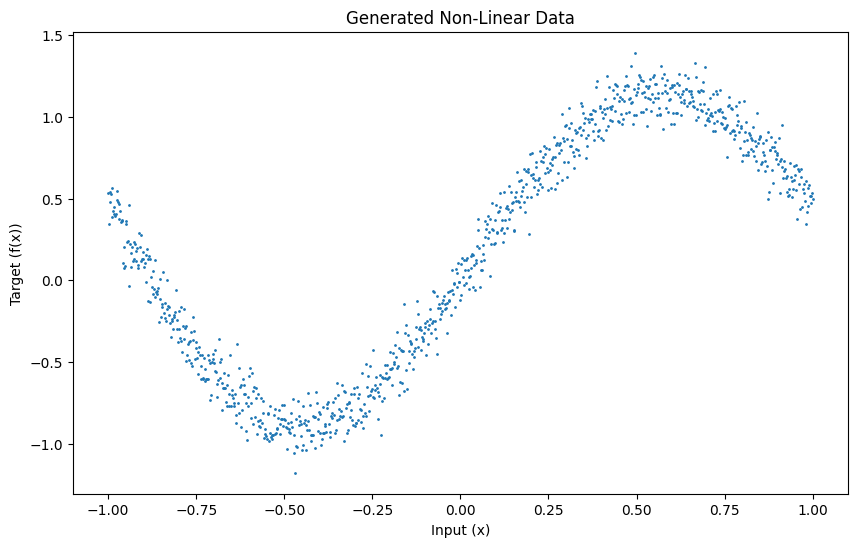

In [3]:
"""
Make some data 

In this simple example, we will set a piece of a sine wave as 
the training data, just for a non linear example. We will not
be extrapolating with the fully connected neural net so it will 
serve the purpose.
"""

num_samples = 1000  # Number of data points
x_range = [-1, 1]  # Range of x values
noise_factor = 0.1  # Noise factor for the data

# Generate input features
inputs = torch.linspace(x_range[0], x_range[1], steps=num_samples).unsqueeze(1)

# Generate targets based on the non-linear function
targets = torch.sin(1 * np.pi * inputs) + 0.5 * torch.pow(inputs, 2)

# Add noise to targets
targets_noisy = targets + torch.randn(targets.shape) * noise_factor

# Split into training and testing sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets_noisy, test_size=0.2)

# Calculate mean and standard deviation of the inputs
inputs_mean = train_inputs.mean()
inputs_std = train_inputs.std()

# Normalize (scale and center) the inputs
train_inputs_normalized = (train_inputs - inputs_mean) / inputs_std
test_inputs_normalized = (test_inputs - inputs_mean) / inputs_std

# Calculate mean and standard deviation of the targets
targets_mean = train_targets.mean()
targets_std = train_targets.std()

# Normalize (scale and center) the targets
train_targets_normalized = (train_targets - targets_mean) / targets_std
test_targets_normalized = (test_targets - targets_mean) / targets_std

# Plot the generated data
plt.figure(figsize=(10, 6))
plt.scatter(inputs.numpy(), targets_noisy.numpy(), s=1)
plt.title("Generated Non-Linear Data")
plt.xlabel("Input (x)")
plt.ylabel("Target (f(x))")
plt.show()



In [4]:
# move to the MPS device
train_inputs_preprocessed_mps = train_inputs_normalized.to('mps')
train_targets_preprocessed_mps = train_targets_normalized.to('mps')
test_inputs_preprocessed_mps = test_inputs_normalized.to('mps')
test_targets_preprocessed_mps = test_targets_normalized.to('mps')

In [5]:
# Initialize the networks and move to MPS device
num_features = 1
hidden_size = 300
hidden_size_2 = 100
output_size = 1

standard_model = None
standard_model = StandardNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2, 
    output_size=1
).to('mps')

custom_model = None
custom_model = CustomNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')

custom_leaky_model = None
custom_leaky_model = CustomLeakyNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')

mixed_model = None
mixed_model = MixedNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')


tiny_model = None
tiny_model = TinyNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    output_size=output_size
).to('mps')

In [14]:
import torch.mps.profiler as pro


# set the model to the model of choice
optimizer = None 
loss = None
criterion = None

model = standard_model

# set criterion and choose adam optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Simple Training loop
num_epochs = 200
for epoch in range(num_epochs):
    # Forward pass
    with torch.mps.profiler.profile(mode='interval', wait_until_completed=True):
        outputs = model(train_inputs_preprocessed_mps)
        loss = criterion(outputs, train_targets_preprocessed_mps)
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #pro.stop()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    # if (epoch+1) % 100 == 0:
    #     for name, param in model.named_parameters():
    #         print(f"Gradients of {name}: {param.grad}")


Epoch [10/200], Loss: 0.2996
Epoch [20/200], Loss: 0.1787
Epoch [30/200], Loss: 0.0832
Epoch [40/200], Loss: 0.0356
Epoch [50/200], Loss: 0.0259
Epoch [60/200], Loss: 0.0215
Epoch [70/200], Loss: 0.0195
Epoch [80/200], Loss: 0.0185
Epoch [90/200], Loss: 0.0181
Epoch [100/200], Loss: 0.0179
Epoch [110/200], Loss: 0.0177
Epoch [120/200], Loss: 0.0177
Epoch [130/200], Loss: 0.0176
Epoch [140/200], Loss: 0.0176
Epoch [150/200], Loss: 0.0175
Epoch [160/200], Loss: 0.0175
Epoch [170/200], Loss: 0.0175
Epoch [180/200], Loss: 0.0175
Epoch [190/200], Loss: 0.0175
Epoch [200/200], Loss: 0.0175


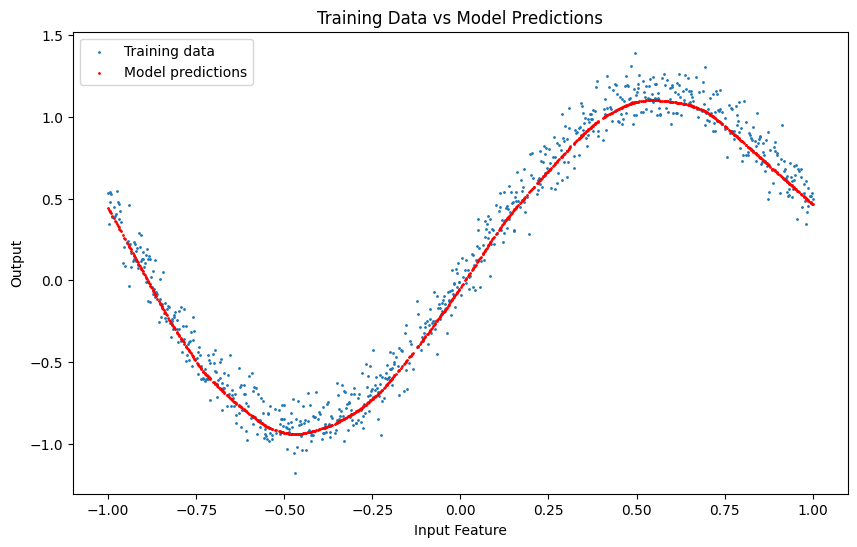

In [15]:
import matplotlib
import matplotlib.pyplot as plt

# Assuming `train_inputs` and `train_outputs` are your training data
# And `model` is your trained model

# Move the data to the same device as the model
#train_inputs, train_outputs = train_inputs.to('mps'), train_targets.to('mps')

# Get predictions from the model
with torch.no_grad():
    predictions = model(train_inputs_preprocessed_mps)

# reverse the center scaling for the predictions
predictions = predictions.cpu()
predictions = (predictions + targets_mean) * targets_std
predictions = predictions.numpy()

# Assuming a single feature for simplicity in plotting
plt.figure(figsize=(10, 6))
plt.scatter(train_inputs[:, 0], train_targets[:, 0], label='Training data', s=1)
plt.scatter(train_inputs[:, 0], predictions[:, 0], label='Model predictions', color='red', s=1)
plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.legend()
plt.title('Training Data vs Model Predictions')
plt.show()


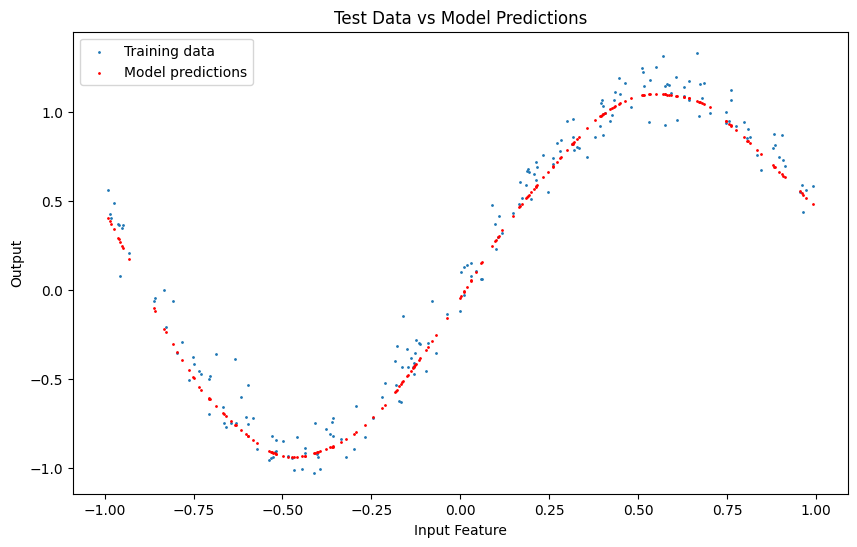

In [18]:
# show the test predictions

# Get predictions from the model
with torch.no_grad():
    predictions = model(test_inputs_preprocessed_mps)

# reverse the center scaling for the predictions
predictions = predictions.cpu()
predictions = (predictions + targets_mean) * targets_std
predictions = predictions.numpy()

# Assuming a single feature for simplicity in plotting
plt.figure(figsize=(10, 6))
plt.scatter(test_inputs[:, 0], test_targets[:, 0], label='Training data', s=1)
plt.scatter(test_inputs[:, 0], predictions[:, 0], label='Model predictions', color='red', s=1)
plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.legend()
plt.title('Test Data vs Model Predictions')
plt.show()


In [19]:
# Inspect Gradients
for name, param in model.named_parameters():
    print(f"Gradients of {name}: {param.grad}")


Gradients of fc1.weight: tensor([[ 0.0000e+00],
        [ 1.0241e-06],
        [ 4.4826e-07],
        [ 2.2201e-06],
        [-9.5604e-06],
        [-3.6044e-06],
        [ 0.0000e+00],
        [-4.4031e-05],
        [ 4.4059e-06],
        [ 2.8469e-06],
        [-1.9131e-06],
        [ 1.3165e-05],
        [ 5.1838e-06],
        [-3.0466e-06],
        [-2.8124e-06],
        [-3.9474e-06],
        [-9.9826e-07],
        [-1.2198e-04],
        [-5.9150e-06],
        [ 7.7146e-06],
        [ 3.1593e-05],
        [-5.5555e-05],
        [ 3.5843e-06],
        [-1.0496e-07],
        [ 1.7722e-06],
        [ 0.0000e+00],
        [-2.7145e-06],
        [ 0.0000e+00],
        [-3.6254e-06],
        [ 2.0828e-06],
        [-8.1670e-07],
        [-1.3184e-06],
        [ 5.1244e-06],
        [-3.3016e-06],
        [ 2.7353e-06],
        [-6.8038e-06],
        [ 1.6287e-07],
        [-8.1336e-06],
        [-5.1564e-05],
        [ 0.0000e+00],
        [-5.3877e-06],
        [ 4.4204e-06],
        [

In [10]:
# Inspect Parameters
for name, param in model.named_parameters():
    print(f"Values of {name}: {param}")


Values of fc1.weight: Parameter containing:
tensor([[ 4.5301e-02],
        [ 3.9306e-01],
        [-8.1420e-01],
        [-5.1818e-01],
        [ 7.5189e-01],
        [-1.8218e-01],
        [ 3.9938e-01],
        [-6.3284e-01],
        [ 5.6596e-01],
        [-3.4287e-01],
        [ 2.7238e-01],
        [ 3.7522e-01],
        [-8.1326e-01],
        [-7.0662e-01],
        [ 9.4406e-01],
        [ 2.6275e-01],
        [-1.7415e-01],
        [ 9.8305e-02],
        [-8.0015e-02],
        [ 8.4561e-01],
        [-2.4190e-01],
        [-4.6312e-01],
        [-9.5845e-02],
        [-8.1136e-01],
        [ 4.9729e-01],
        [-2.7508e-01],
        [ 8.3771e-01],
        [ 5.9890e-01],
        [ 3.0833e-01],
        [ 3.8707e-02],
        [ 3.0186e-01],
        [-7.2015e-01],
        [ 6.2139e-01],
        [-3.1191e-01],
        [-5.8915e-01],
        [-7.7606e-01],
        [ 4.9758e-01],
        [ 2.1486e-01],
        [-6.7331e-01],
        [ 6.8314e-01],
        [-6.0393e-01],
        [-6.0